In [157]:
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
import liyc_utils
import imp
imp.reload(liyc_utils)
from liyc_utils import *

In [9]:
# get all PE2 data
Anzalone_PE2 = pd.read_csv("../Anzalone_2019.feature_matrix.csv",index_col=0)
Anzalone_PE2 = Anzalone_PE2[Anzalone_PE2.nick_to_pegRNA.isnull()]
print (Anzalone_PE2.shape) # should be 199
DeepPE = pd.read_csv("../DeepPE.feature_matrix.csv")
DeepPE.head()

(199, 24)


,0,1,2,3,4,5,6,7,8,9,...,PBS_GC,pbs_length,N_subsitution,N_deletion,N_insertions,Target_pos,Target_end_flank,dPAM,Target,type
0,0.014121,0.078609,0.084057,0.069852,0.030430,0.127499,0.151544,0.160713,0.356425,0.403223,...,0.000000,7,1,0,0,5,5,1,0.035112,HT-Training
1,0.012820,0.108751,0.115446,0.095017,0.039857,0.169858,0.199350,0.208493,0.457740,0.506339,...,0.111111,9,1,0,0,5,5,1,0.041597,HT-Training
2,0.067959,0.057805,0.289287,0.271866,0.046149,0.173783,0.205551,0.225851,0.228371,0.103900,...,0.285714,7,1,0,0,5,5,1,0.571349,HT-Training
3,0.030946,0.036186,0.608230,0.664821,0.712692,0.222262,0.147150,0.210832,0.200757,0.358130,...,0.428571,7,1,0,0,5,5,1,0.691117,HT-Training
4,0.990892,0.034533,0.034230,0.120242,0.146871,0.126390,0.046216,0.019104,0.263842,0.319650,...,0.285714,7,1,0,0,5,5,1,6.761687,HT-Training


In [10]:
print (Anzalone_PE2.columns.tolist())
print (DeepPE.columns.tolist())

['Target', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'cas9_score', 'nick_to_pegRNA', 'dPAM', 'PE3b', 'RTT_GC', 'RTT_length', 'PBS_GC', 'PBS_length', 'N_subsitution', 'N_deletion', 'N_insertions', 'Target_pos', 'Target_end_flank']
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'cas9_score', 'RTT_GC', 'rtt_length', 'PBS_GC', 'pbs_length', 'N_subsitution', 'N_deletion', 'N_insertions', 'Target_pos', 'Target_end_flank', 'dPAM', 'Target', 'type']


In [47]:
f1 = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'cas9_score', 'RTT_GC', 'RTT_length', 'PBS_GC', 'PBS_length', 'N_subsitution', 'N_deletion', 'N_insertions', 'Target_pos', 'Target_end_flank','dPAM']
f2 = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'cas9_score', 'RTT_GC', 'rtt_length', 'PBS_GC', 'pbs_length', 'N_subsitution', 'N_deletion', 'N_insertions', 'Target_pos', 'Target_end_flank', 'dPAM']
d1 = Anzalone_PE2[f1+['type','Target']]
d2 = DeepPE[f2+['type','Target']]
d2.columns = f1+['type','Target']
df = pd.concat([d1,d2])

In [159]:
DeepPE.shape

(46614, 23)

In [16]:
# build ML model

In [58]:
# CV applied to train set, for tuning parameters, test set is tested independently
def xgb_reg(par=False):
	est = XGBRegressor()
	if par:
		est = XGBRegressor(seed=0,n_jobs=1,**par)
	myDict = {}
	myDict['max_depth']=[2,5,9]
	myDict['learning_rate'] = [0.01,0.1]
	myDict['min_child_weight']=[1,5,10]
	myDict['colsample_bylevel']=[0.6,1]
	myDict['colsample_bytree']=[0.6,1]
	myDict['subsample']=[0.6,1]
	myDict['reg_alpha']=[0,0.1,1]
	myDict['reg_lambda']=[0,1,2]
	return est, myDict

def model_training(X_train,y_train,X_test,y_test,par):
    model,_ = xgb_reg(par)
    model.fit(X_train,y_train)
    myPred = model.predict(X_test)
    my_pred = myPred.tolist()
    my_true = y_test.tolist()
    r,p = scipy.stats.pearsonr(my_true,my_pred)
    sr,sp = scipy.stats.spearmanr(my_true,my_pred)
    r2 = r2_score(my_true,my_pred)
    mae = mean_absolute_error(my_true,my_pred)   
    mse = mean_squared_error(my_true,my_pred)       
    return [r,sr,r2,mae,mse]

def CV_tune_parameter(X,y,nfold):
    """CV code
    
    X is pandas dataframe
    y is pandas Series
    X,y have the same index
    """
    kf = KFold(n_splits=nfold,shuffle=True,random_state=0)
    index_list = X.index.tolist()
    my_pred=[]
    my_true=[]
    best_parameter_list = []
    _,parameter_dict = xgb_reg()
    p_list = list(ParameterGrid(parameter_dict))
    print ("Parameter Space: ",len(p_list))
    for j,i in kf.split(index_list):
        train_group = [index_list[x] for x in i]
        test_group = [index_list[x] for x in j]
        X_train = X.loc[train_group]
        X_test = X.loc[test_group]
        y_train = y.loc[train_group]
        y_test = y.loc[test_group]        
        print (X_train.shape,X_test.shape)
        result_list = Parallel(n_jobs=20,verbose=0,backend='multiprocessing')(delayed(model_training)(X_train,y_train,X_test,y_test,p) for p in p_list)
        result_df = pd.DataFrame(result_list)
        result_df['parameters'] = p_list
#         result_df = result_df.loc[result_df[2].idxmax()]  
        result_df = result_df.loc[result_df[4].idxmin()]  
        best_line = result_df.values.tolist()
        print (result_df)
        best_parameter_list.append(best_line[-1])
    return best_parameter_list
X_train = df[df.type.str.contains("Train",case=False)][f1]
X_test = df[df.type.str.contains("Test",case=False)][f1]
Target = "Target"
y_train = df[df.type.str.contains("Train",case=False)][Target]
y_test = df[df.type.str.contains("Test",case=False)][Target]

best_parameter_list = CV_tune_parameter(X_train,y_train,5)

Parameter Space:  1296
(8401, 21) (33601, 21)
0                                                      0.701011
1                                                      0.727654
2                                                      0.487060
3                                                      4.884128
4                                                     40.640977
parameters    {'colsample_bylevel': 1, 'colsample_bytree': 0...
Name: 935, dtype: object
(8401, 21) (33601, 21)
0                                                      0.698312
1                                                      0.721751
2                                                      0.485217
3                                                      4.849798
4                                                     40.728240
parameters    {'colsample_bylevel': 1, 'colsample_bytree': 0...
Name: 923, dtype: object
(8400, 21) (33602, 21)
0                                                      0.707252
1                         

Pearson correlation: 0.6302259547148568
Spearman correlation: 0.6654792575815065


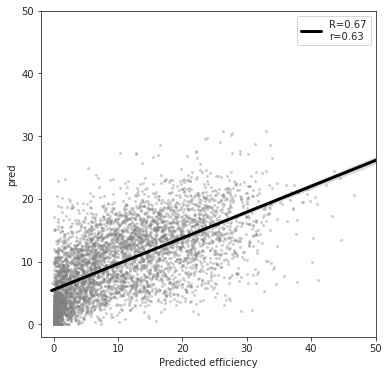

In [101]:
model,_ = xgb_reg(best_parameter_list[0])
model.fit(X_train,y_train)
myPred = model.predict(X_test)
my_pred = [0 if i < 0 else i for i in myPred.tolist()]
my_true = y_test.tolist()
index_list = X_test.index.tolist()
outer_df = pd.DataFrame()
outer_df['true'] = my_true
outer_df['pred'] = my_pred
outer_df.index = index_list
r,p = scipy.stats.pearsonr(my_true,my_pred)
sr,p = scipy.stats.spearmanr(my_true,my_pred)
print ("Pearson correlation: %s"%(r))
print ("Spearman correlation: %s"%(sr))

%matplotlib inline

plot_ML_scatter(my_true,my_pred,"PE2_model",50)

In [124]:
X = df[f1]
y = df[Target]
final_model,_ = xgb_reg(best_parameter_list[0])
final_model.fit(X,y)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=100, reg_alpha=1,
             reg_lambda=2, scale_pos_weight=1, seed=100, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

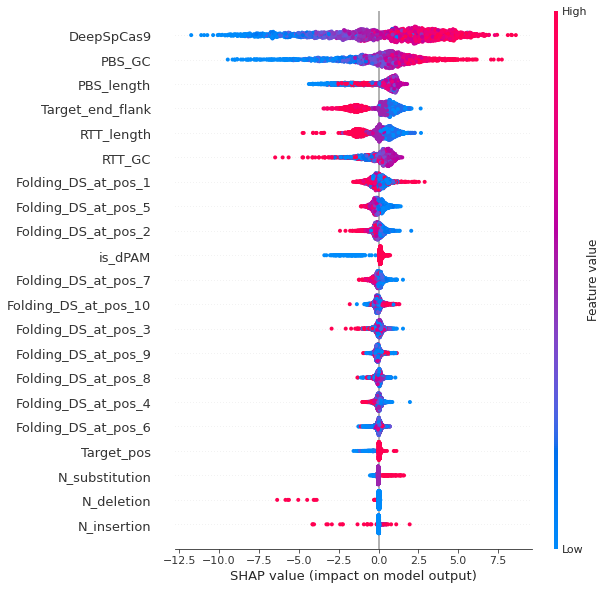

In [252]:
shap.plots.beeswarm(shap_values,max_display=100)
output_file="PE2_model"
plt.savefig("%s.SHAP.beeswarm.pdf"%(output_file),bbox_inches='tight')

In [251]:
shap_values.feature_names= ['Folding_DS_at_pos_1',
 'Folding_DS_at_pos_2',
 'Folding_DS_at_pos_3',
 'Folding_DS_at_pos_4',
 'Folding_DS_at_pos_5',
 'Folding_DS_at_pos_6',
 'Folding_DS_at_pos_7',
 'Folding_DS_at_pos_8',
 'Folding_DS_at_pos_9',
 'Folding_DS_at_pos_10',
 'DeepSpCas9',
 'RTT_GC',
 'RTT_length',
 'PBS_GC',
 'PBS_length',
 'N_substitution',
 'N_deletion',
 'N_insertion',
 'Target_pos',
 'Target_end_flank',
 'is_dPAM']

In [17]:
# get feature importance

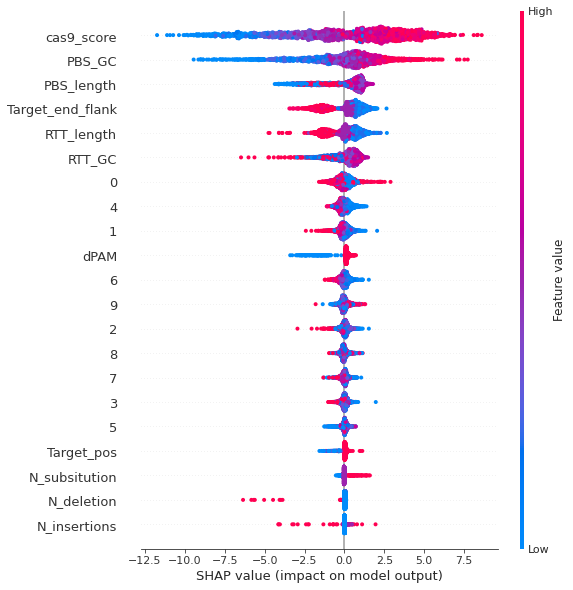

<Figure size 432x288 with 0 Axes>

In [154]:
explainer = shap.Explainer(final_model)
shap_values = explainer(X.sample(2000))
shap.plots.beeswarm(shap_values,max_display=100)
output_file="PE2_model"
plt.savefig("%s.SHAP.beeswarm.pdf"%(output_file),bbox_inches='tight')

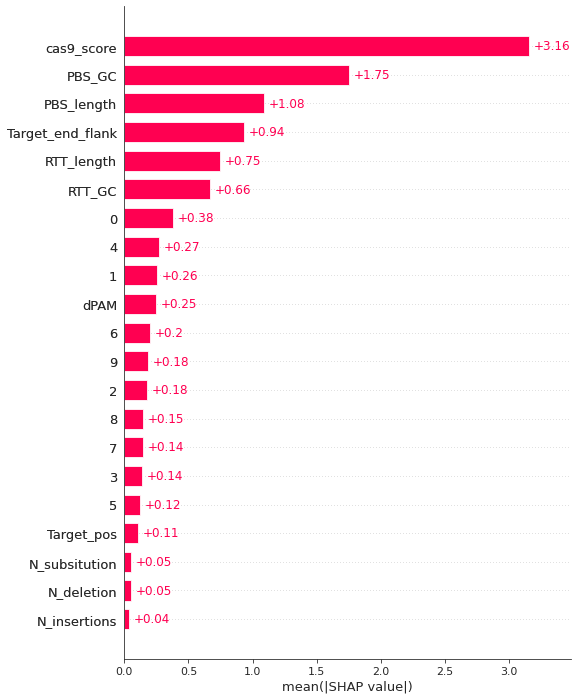

<Figure size 432x288 with 0 Axes>

In [155]:


shap.plots.bar(shap_values.abs.mean(0),max_display=100)
plt.savefig("%s.SHAP.barplot.pdf"%(output_file),bbox_inches='tight')

In [194]:
ss = pd.DataFrame(shap_values.values)
ss.columns = X.columns.tolist()
ss.head()

,0,1,2,3,4,5,6,7,8,9,...,RTT_GC,RTT_length,PBS_GC,PBS_length,N_subsitution,N_deletion,N_insertions,Target_pos,Target_end_flank,dPAM
0,2.252514,-0.337869,-0.027721,0.223270,0.454173,0.031761,0.169084,-0.019860,-0.253626,-0.085775,...,-0.634733,2.012535,2.886000,-0.907260,-0.017787,0.022097,0.008150,0.119829,1.907899,0.136915
1,0.191610,0.108371,0.055788,-0.123405,-0.102050,0.043388,-0.170179,0.016882,0.066270,-0.198488,...,-0.589970,-0.800678,-1.944599,-0.447366,-0.016982,0.014120,0.011327,0.050894,-0.715217,0.083486
2,-0.179233,0.203752,0.389270,0.029005,-0.398698,0.222258,0.232535,0.653001,0.071009,-0.017194,...,-0.385775,0.386612,0.499349,-2.065638,-0.055526,0.033164,-0.003643,0.021813,0.373942,0.158172
3,0.116150,-0.491166,-0.298237,-0.401670,0.418222,0.112142,0.055763,0.093026,0.176959,-0.134308,...,-0.367817,0.313495,-3.461382,0.338664,-0.009649,0.015505,0.003265,0.026590,0.443567,0.061069
4,0.854066,0.113714,-0.139101,-0.244502,0.006654,-0.040939,-0.386930,0.251320,0.634918,-0.024833,...,0.614594,1.034338,1.188917,0.696708,0.012537,0.024813,0.015326,0.054961,1.203748,0.279219


In [195]:
ss['cas9_score'].abs().mean(0)

3.156269

cas9_score          3.156267
RTT_GC              0.664313
RTT_length          0.748400
PBS_GC              1.751219
PBS_length          1.084913
N_subsitution       0.050233
N_deletion          0.050189
N_insertions        0.035991
Target_pos          0.108962
Target_end_flank    0.935229
dPAM                0.248608
RNA_Folding         2.007015
dtype: float64


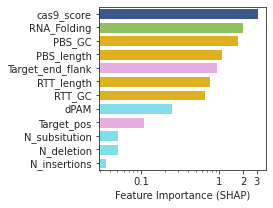

In [246]:
color_dict={}
color_dict["Oligo Features"] = "#FFC000"
color_dict["RNA Folding Features"] = "#92D050"
color_dict["Position Features"] = "#F1A4E8"
color_dict["Mutation Features"] = "#6EEBFB"
color_dict["Cas9 Activity Feature"] = "#2F5597"
feature_type_dict = {}
feature_type_dict["PBS_GC"] = "Oligo Features"
feature_type_dict["RTT_GC"] = "Oligo Features"
feature_type_dict["PBS_length"] = "Oligo Features"
feature_type_dict["RTT_length"] = "Oligo Features"
feature_type_dict["Target_pos"] = "Position Features"
feature_type_dict["Target_end_flank"] = "Position Features"
feature_type_dict["dPAM"] = "Mutation Features"
feature_type_dict["N_subsitution"] = "Mutation Features"
feature_type_dict["N_deletion"] = "Mutation Features"
feature_type_dict["N_insertions"] = "Mutation Features"
feature_type_dict["cas9_score"] = "Cas9 Activity Feature"
feature_type_dict["RNA_Folding"] = "RNA Folding Features"


plot_df = ss.abs().mean(0)


RNA_folding = plot_df.loc[[str(x) for x in range(10)]].sum()
plot_df = plot_df.iloc[10:]
plot_df = plot_df.append(pd.Series([RNA_folding],index=["RNA_Folding"]))
print (plot_df)
plot_df = plot_df.reset_index()
plot_df.columns = ['Name','SHAP']
plot_df['feature_type']= plot_df.Name.map(feature_type_dict)
plot_df['color']= plot_df.feature_type.map(color_dict)
# print (plot_df)
plot_df.index = plot_df['Name'].tolist()
plot_df = plot_df.sort_values("SHAP",ascending=False)
plt.figure(figsize=(3,3))
# df['SHAP']=0
ax=sns.barplot(data=plot_df,y="Name",x="SHAP",palette=plot_df.color.to_dict(),alpha=1)
# plt.xticks(rotation=90) 
# plt.yticks(rotation=90) 
plt.xlabel("Feature Importance (SHAP)")
plt.ylabel("")
# plt.xlim(0.0005,0.12)
ax.set_xscale("log")
ax.set_xticks([0.1,1, 2,3])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticklabels(["0.1","1","2","3"])
# myList = []
# for c in color_dict:
#     xx = mpatches.Patch(color=color_dict[c], label=c)
#     myList.append(xx)
# plt.legend(handles=myList,title="Types",loc="lower right")
# plt.savefig("feature_importance_PE2.pdf",bbox_inches="tight")
plt.savefig("feature_importance_PE2.eps",bbox_inches="tight")